In [ ]:
!nvidia-smi

Tue Oct 17 16:44:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  Off  | 00000000:E1:00.0 Off |                    0 |
| N/A   48C    P0    37W / 250W |      4MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.utils import save_image
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR_COVER = "Cover image"
TRAIN_DIR_HIDDEN = "FD"
VAL_DIR = "data/val"
LR_ENCODER = 0.001
LR_DECODER = 0.001
LR_DISCRIMINATOR = 0.0005
BATCH_SIZE = 16
NUM_EPOCHS = 500
BETA = 0.75
GAMMA = 1
NUM_WORKERS = 2
CHECKPOINT_DISC = "disc.pth.tar"
CHECKPOINT_ENC = "enc.pth.tar"
CHECKPOINT_DEC = "dec.pth.tar"

In [4]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.5):
        super(ResNetBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels))

        # Shortcut connection (if necessary)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels))

    def forward(self, x):
        # Main path
        out = self.block(x)
        # Shortcut path
        shortcut = self.shortcut(x)
        # Add the main path and the shortcut path
        out += shortcut
        return out


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            #Downsampling
            nn.Conv2d(6, 64, 7, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, padding=1, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, padding=1, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            #9 resnet blocks
            ResNetBlock(in_channels=256, out_channels=256),
            ResNetBlock(in_channels=256, out_channels=256),
            ResNetBlock(in_channels=256, out_channels=256),
            ResNetBlock(in_channels=256, out_channels=256),
            ResNetBlock(in_channels=256, out_channels=256),
            ResNetBlock(in_channels=256, out_channels=256),
            ResNetBlock(in_channels=256, out_channels=256),
            ResNetBlock(in_channels=256, out_channels=256),
            ResNetBlock(in_channels=256, out_channels=256),
            #Upsampling
            nn.ConvTranspose2d(256, 128, 4, padding=1, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, padding=1, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, 7, padding=3),
            nn.Tanh())

    def forward(self, x):
        out = self.model(x)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, 3, padding=1),
            nn.BatchNorm2d(3),
            nn.Sigmoid())

    def forward(self, x):
        out = self.model(x)
        return out

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.Conv2d(64, 3, 3, padding=1),
            nn.Sigmoid())

    def forward(self, x):
        out = self.model(x)
        return out

In [5]:
class MapDataset(Dataset):
    def __init__(self, root_dir_cover, root_dir_hidden):
        self.root_dir_cover = root_dir_cover
        self.list_files_cover = os.listdir(self.root_dir_cover)
        self.root_dir_hidden = root_dir_hidden
        self.list_files_hidden = os.listdir(self.root_dir_hidden)

    def __len__(self):
        return len(self.list_files_cover)

    def __getitem__(self, index):
        img_file_cover = self.list_files_cover[index]
        #print(img_file_cover)
        img_path_cover = os.path.join(self.root_dir_cover, img_file_cover)
        cover = np.array(Image.open(img_path_cover))
        img_file_hidden = self.list_files_hidden[index]
        #print(img_file_hidden)
        img_path_hidden = os.path.join(self.root_dir_hidden, img_file_hidden)
        hidden = np.array(Image.open(img_path_hidden))

        transform = A.Compose(
            [A.Resize(width=256, height=256),
             A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,), ToTensorV2(),],
        )

        t_cover = transform(image=cover)["image"]
        t_hidden = transform(image=hidden)["image"]
        #print(t_cover,t_hidden)

        return t_cover, t_hidden


In [6]:
def save_some_examples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5  # remove normalization#
        save_image(y_fake, folder + f"/y_gen_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        if epoch == 1:
            save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
    gen.train()


def save_checkpoint(model, optimizer, loss, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "loss": loss,
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [7]:
def train_fn(loader, disc, encoder, decoder, opt_enc, opt_dec, opt_disc, mse, bce, beta, gamma):
    loop = tqdm(loader, leave=True)
    total_encoder_loss = 0.0
    total_decoder_loss = 0.0
    total_discriminator_loss = 0.0
    for idx, (cover, secret) in enumerate(loop):
        #print(idx,secret.shape)
        secret, cover = secret.to(DEVICE), cover.to(DEVICE)
        #display_image(secret)
        combined = torch.cat((secret,cover),1)
        #print(combined.shape)
        stego = encoder(combined).to(DEVICE)
        retrieve = decoder(stego).to(DEVICE)
        disc_result = disc(stego).to(DEVICE)
        #print(stego.shape)
        #print(retrieve.shape)

        encoder_mse = mse(stego, cover)
        decoder_mse = mse(retrieve, secret)
        gen_disc_loss = bce(disc_result, torch.ones(stego.size()).to(DEVICE))

        total_encoder_loss += encoder_mse.item()
        total_decoder_loss += decoder_mse.item()
        total_discriminator_loss += gen_disc_loss.item()

        loss = encoder_mse + beta*decoder_mse + gamma*gen_disc_loss
        opt_enc.zero_grad()
        opt_dec.zero_grad()
        loss.backward(retain_graph=True)
        opt_enc.step()
        opt_dec.step()

        if idx % 2 == 0:
            disc_cover = disc(cover).to(DEVICE)
            disc_stego = disc(stego).to(DEVICE)
            discover = bce(disc_cover, torch.ones(disc_cover.size()).to(DEVICE))
            disstego = bce(disc_stego, torch.zeros(disc_stego.size()).to(DEVICE))
            disloss = discover + disstego
            disc.zero_grad()
            disloss.backward(retain_graph=False)
            opt_disc.step()
    return total_encoder_loss / len(loader), total_decoder_loss / len(loader), total_discriminator_loss / len(loader)

def display_image(cover, hidden, stego, retrieve):
    cover = cover[0].cpu().permute(1, 2, 0).detach().numpy()
    hidden = hidden[0].cpu().permute(1, 2, 0).detach().numpy()
    stego = stego[0].cpu().permute(1, 2, 0).detach().numpy()
    retrieve = retrieve[0].cpu().permute(1, 2, 0).detach().numpy()
    fig, axes = plt.subplots(1, 4, figsize=(7, 3))
    axes[0].imshow(cover)
    axes[1].imshow(hidden)
    axes[2].imshow(stego)
    axes[3].imshow(retrieve)
    for ax in axes.flat:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def main():
    disc = Discriminator().to(DEVICE)
    encoder = Encoder().to(DEVICE)
    decoder = Decoder().to(DEVICE)
    opt_disc = optim.SGD(disc.parameters(), lr=LR_DISCRIMINATOR)
    opt_enc = optim.Adam(encoder.parameters(), lr=LR_ENCODER)
    opt_dec = optim.Adam(decoder.parameters(), lr=LR_DECODER)
    bce = nn.BCELoss().to(DEVICE)
    mse = nn.MSELoss().to(DEVICE)
    disc_scheduler = torch.optim.lr_scheduler.StepLR(opt_disc, step_size=4, gamma=0.9)
    enc_scheduler = torch.optim.lr_scheduler.StepLR(opt_enc, step_size=4, gamma=0.9)
    dec_scheduler = torch.optim.lr_scheduler.StepLR(opt_dec, step_size=4, gamma=0.9)

    #Load dataset
    train_dataset = MapDataset(root_dir_cover=TRAIN_DIR_COVER, root_dir_hidden=TRAIN_DIR_HIDDEN)
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
    )

    for i in range(NUM_EPOCHS):
        encoder_loss, decoder_loss, discriminator_loss = train_fn(train_loader, disc, encoder, decoder, opt_enc, opt_dec, opt_disc, mse, bce, BETA, GAMMA)
        disc_scheduler.step()
        enc_scheduler.step()
        dec_scheduler.step()
        print(f'Epoch [{i}/{NUM_EPOCHS}] | Encoder Loss: {encoder_loss} | Decoder Loss: {decoder_loss} | Discriminator Loss: {discriminator_loss}')
        if i % 5 == 0:
            save_checkpoint(encoder, opt_enc, encoder_loss, filename=CHECKPOINT_ENC)
            save_checkpoint(decoder, opt_dec, decoder_loss, filename=CHECKPOINT_DEC)
            save_checkpoint(disc, opt_disc, discriminator_loss, filename=CHECKPOINT_DISC)

        if i % 10 == 0:
            with torch.no_grad():
                secret, cover = next(iter(train_loader))
                secret, cover = secret.to(DEVICE), cover.to(DEVICE)
                combined = torch.cat((cover, secret), 1)
                stego = encoder(combined).to(DEVICE)
                retrieve = decoder(stego).to(DEVICE)
                disc_result = disc(stego).to(DEVICE)
                display_image(cover, secret, stego, retrieve)

In [8]:
def main2():
    check = torch.load('disc.pth.tar')
    disc = Discriminator().to(DEVICE)
    opt_disc = optim.SGD(disc.parameters(), lr=LR_DISCRIMINATOR)
    disc.load_state_dict(check['state_dict'])
    opt_disc.load_state_dict(check['optimizer'])
    check = torch.load('enc.pth.tar')
    encoder = Encoder().to(DEVICE)
    opt_enc = optim.Adam(encoder.parameters(), lr=LR_ENCODER)
    encoder.load_state_dict(check['state_dict'])
    opt_enc.load_state_dict(check['optimizer'])
    check = torch.load('dec.pth.tar')
    decoder = Decoder().to(DEVICE)
    decoder.load_state_dict(check['state_dict'])
    opt_dec = optim.Adam(decoder.parameters(), lr=LR_DECODER)
    opt_dec.load_state_dict(check['optimizer'])
    bce = nn.BCELoss().to(DEVICE)
    mse = nn.MSELoss().to(DEVICE)
    disc_scheduler = torch.optim.lr_scheduler.StepLR(opt_disc, step_size=6, gamma=0.9)
    enc_scheduler = torch.optim.lr_scheduler.StepLR(opt_enc, step_size=6, gamma=0.9)
    dec_scheduler = torch.optim.lr_scheduler.StepLR(opt_dec, step_size=6, gamma=0.9)

    train_dataset = MapDataset(root_dir_cover=TRAIN_DIR_COVER, root_dir_hidden=TRAIN_DIR_HIDDEN)
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
    )
    for i in range(NUM_EPOCHS):
        encoder_loss, decoder_loss, discriminator_loss = train_fn(train_loader, disc, encoder, decoder, opt_enc, opt_dec, opt_disc, mse, bce, BETA, GAMMA)
        disc_scheduler.step()
        enc_scheduler.step()
        dec_scheduler.step()
        print(f'Epoch [{i}/{NUM_EPOCHS}] | Encoder Loss: {encoder_loss} | Decoder Loss: {decoder_loss} | Discriminator Loss: {discriminator_loss}')
        if i % 5 == 0:
            save_checkpoint(encoder, opt_enc, encoder_loss, filename=CHECKPOINT_ENC)
            save_checkpoint(decoder, opt_dec, decoder_loss, filename=CHECKPOINT_DEC)
            save_checkpoint(disc, opt_disc, discriminator_loss, filename=CHECKPOINT_DISC)

        if i % 10 == 0:
            with torch.no_grad():
                secret, cover = next(iter(train_loader))
                secret, cover = secret.to(DEVICE), cover.to(DEVICE)
                combined = torch.cat((cover, secret), 1)
                stego = encoder(combined).to(DEVICE)
                retrieve = decoder(stego).to(DEVICE)
                disc_result = disc(stego).to(DEVICE)
                display_image(cover, secret, stego, retrieve)

100%|██████████| 167/167 [01:08<00:00,  2.44it/s]


Epoch [0/500] | Encoder Loss: 0.07314743346975235 | Decoder Loss: 0.15364746008804459 | Discriminator Loss: 0.7468321473298672
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


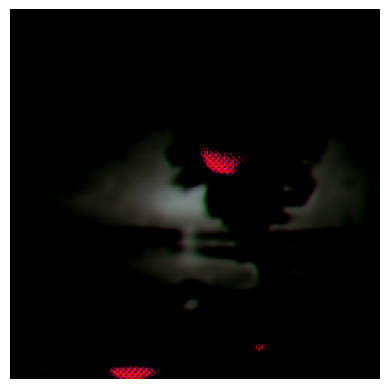

100%|██████████| 167/167 [01:07<00:00,  2.48it/s]


Epoch [1/500] | Encoder Loss: 0.055736914210155336 | Decoder Loss: 0.147590344537518 | Discriminator Loss: 0.7286024115042772


100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [2/500] | Encoder Loss: 0.0511421989091856 | Decoder Loss: 0.1475922352896479 | Discriminator Loss: 0.7239886433064581


100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [3/500] | Encoder Loss: 0.04684177186050101 | Decoder Loss: 0.14758965132122268 | Discriminator Loss: 0.7214591781536263


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [4/500] | Encoder Loss: 0.039479677314440645 | Decoder Loss: 0.1475910122344594 | Discriminator Loss: 0.7150404442570166


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [5/500] | Encoder Loss: 0.032290657881848116 | Decoder Loss: 0.14759442254811703 | Discriminator Loss: 0.715841259071213
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [6/500] | Encoder Loss: 0.0289507997138593 | Decoder Loss: 0.14759435589441997 | Discriminator Loss: 0.7135183675560409


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [7/500] | Encoder Loss: 0.02484817449338065 | Decoder Loss: 0.14759178531027126 | Discriminator Loss: 0.7115369392726236


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [8/500] | Encoder Loss: 0.022227471376473674 | Decoder Loss: 0.14759025807509166 | Discriminator Loss: 0.7107924801146913


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [9/500] | Encoder Loss: 0.021277670202007194 | Decoder Loss: 0.1475929681234017 | Discriminator Loss: 0.7101123811242109


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [10/500] | Encoder Loss: 0.02323808718450412 | Decoder Loss: 0.1475940139707691 | Discriminator Loss: 0.7114909027151005
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


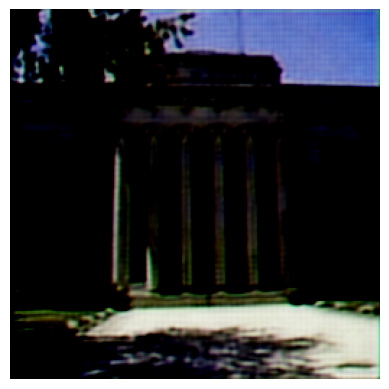

100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [11/500] | Encoder Loss: 0.020679734318243888 | Decoder Loss: 0.147590934159513 | Discriminator Loss: 0.7093727206755541


100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [12/500] | Encoder Loss: 0.02269852233905635 | Decoder Loss: 0.1475905542245168 | Discriminator Loss: 0.7141843609467238


100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [13/500] | Encoder Loss: 0.02072450878868203 | Decoder Loss: 0.14759438685671297 | Discriminator Loss: 0.7112960140862151


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [14/500] | Encoder Loss: 0.01805714353874415 | Decoder Loss: 0.14758777886093732 | Discriminator Loss: 0.7086356988923992


100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [15/500] | Encoder Loss: 0.023309452431332207 | Decoder Loss: 0.14759326953730897 | Discriminator Loss: 0.7155451025077683
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [16/500] | Encoder Loss: 0.02000774908810854 | Decoder Loss: 0.14759310946136178 | Discriminator Loss: 0.7135229571136886


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [17/500] | Encoder Loss: 0.017182586034257968 | Decoder Loss: 0.14759185098245473 | Discriminator Loss: 0.7095055829978989


100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [18/500] | Encoder Loss: 0.016794674315986163 | Decoder Loss: 0.1475907343768788 | Discriminator Loss: 0.7083413372496645


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [19/500] | Encoder Loss: 0.016081037479424905 | Decoder Loss: 0.1475949405196184 | Discriminator Loss: 0.7081964587023158


100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [20/500] | Encoder Loss: 0.014973597746052428 | Decoder Loss: 0.14759085742299427 | Discriminator Loss: 0.7071067041265751
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


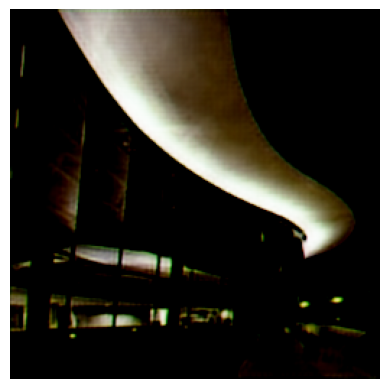

100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [21/500] | Encoder Loss: 0.014440579049869211 | Decoder Loss: 0.14759496461131616 | Discriminator Loss: 0.707107987946379


100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [22/500] | Encoder Loss: 0.014082491810539525 | Decoder Loss: 0.14759170464769808 | Discriminator Loss: 0.7068897160941255


100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [23/500] | Encoder Loss: 0.01415017273410887 | Decoder Loss: 0.14759296562500343 | Discriminator Loss: 0.707136649214579


100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [24/500] | Encoder Loss: 0.012852762078498295 | Decoder Loss: 0.14759203416858604 | Discriminator Loss: 0.7065123383870382


100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [25/500] | Encoder Loss: 0.013544888207744696 | Decoder Loss: 0.14759208984717637 | Discriminator Loss: 0.7077581850354543
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [26/500] | Encoder Loss: 0.013639243235978895 | Decoder Loss: 0.14759469094747554 | Discriminator Loss: 0.7074031365845732


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [27/500] | Encoder Loss: 0.012724156837218894 | Decoder Loss: 0.1475905401264122 | Discriminator Loss: 0.7063744032454348


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [28/500] | Encoder Loss: 0.011641986790799095 | Decoder Loss: 0.14759594014661756 | Discriminator Loss: 0.7063450020944287


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [29/500] | Encoder Loss: 0.011142954715488557 | Decoder Loss: 0.1475931062491354 | Discriminator Loss: 0.7060781635210186


100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [30/500] | Encoder Loss: 0.01113211201269648 | Decoder Loss: 0.1475866691259567 | Discriminator Loss: 0.7060320926997476
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


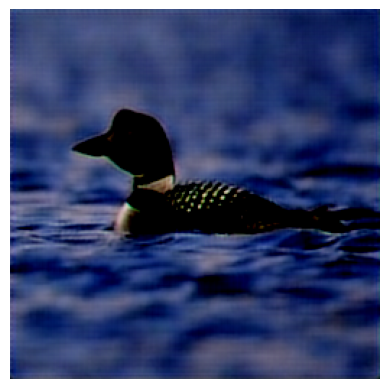

100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [31/500] | Encoder Loss: 0.011638907250016928 | Decoder Loss: 0.14759182376775912 | Discriminator Loss: 0.7060069220508643


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [32/500] | Encoder Loss: 0.010355222108634468 | Decoder Loss: 0.147593656789043 | Discriminator Loss: 0.7059162005692899


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [33/500] | Encoder Loss: 0.01026286533336618 | Decoder Loss: 0.14759199803103945 | Discriminator Loss: 0.7058201196664822


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [34/500] | Encoder Loss: 0.010117378972559989 | Decoder Loss: 0.14759217693420226 | Discriminator Loss: 0.7057288128458811


100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [35/500] | Encoder Loss: 0.009782028426332566 | Decoder Loss: 0.14759005106494813 | Discriminator Loss: 0.7056138918785277
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [36/500] | Encoder Loss: 0.010735406286590648 | Decoder Loss: 0.1475934404991344 | Discriminator Loss: 0.7066321162406556


100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [37/500] | Encoder Loss: 0.009777655663292207 | Decoder Loss: 0.1475929945350407 | Discriminator Loss: 0.7059812192431467


100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [38/500] | Encoder Loss: 0.008984626638898235 | Decoder Loss: 0.14759201775054018 | Discriminator Loss: 0.705572898873312


100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [39/500] | Encoder Loss: 0.009511919510913288 | Decoder Loss: 0.1475914117997278 | Discriminator Loss: 0.7055956235902752


100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [40/500] | Encoder Loss: 0.009314925786286236 | Decoder Loss: 0.14758704852558183 | Discriminator Loss: 0.7053875737561437
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


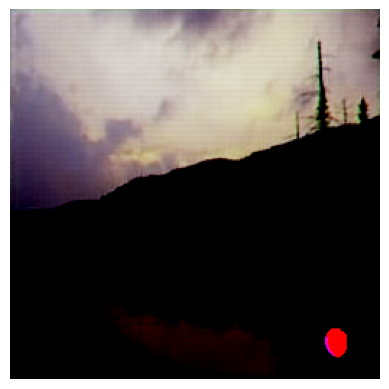

100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [41/500] | Encoder Loss: 0.008620173143345617 | Decoder Loss: 0.14758982942132892 | Discriminator Loss: 0.7052954239045789


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [42/500] | Encoder Loss: 0.00859913070725199 | Decoder Loss: 0.14759082815604296 | Discriminator Loss: 0.7052811612626035


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [43/500] | Encoder Loss: 0.008215824828042598 | Decoder Loss: 0.14759531635010315 | Discriminator Loss: 0.7052449826708811


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [44/500] | Encoder Loss: 0.008094692429873401 | Decoder Loss: 0.14759131935899128 | Discriminator Loss: 0.705146444414904


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [45/500] | Encoder Loss: 0.007923906259127185 | Decoder Loss: 0.1475889600679546 | Discriminator Loss: 0.7050973480333111
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [46/500] | Encoder Loss: 0.007916444427372809 | Decoder Loss: 0.14759374093152805 | Discriminator Loss: 0.7051192664814566


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [47/500] | Encoder Loss: 0.007695489306515919 | Decoder Loss: 0.14759388084183195 | Discriminator Loss: 0.7050544976474282


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [48/500] | Encoder Loss: 0.007722464189334901 | Decoder Loss: 0.14759675239374537 | Discriminator Loss: 0.7051779856224973


100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [49/500] | Encoder Loss: 0.008404122141306985 | Decoder Loss: 0.1475940827659504 | Discriminator Loss: 0.7052177797534509


100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [50/500] | Encoder Loss: 0.0074445901767624 | Decoder Loss: 0.14758909953211596 | Discriminator Loss: 0.7049486430105335
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


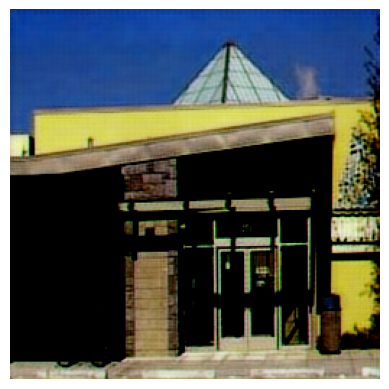

100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [51/500] | Encoder Loss: 0.007529099466290302 | Decoder Loss: 0.14759064309611292 | Discriminator Loss: 0.7049913249329892


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [52/500] | Encoder Loss: 0.00698016615986021 | Decoder Loss: 0.1475906510374503 | Discriminator Loss: 0.7048699302587681


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [53/500] | Encoder Loss: 0.0071256124598537375 | Decoder Loss: 0.14759164370462566 | Discriminator Loss: 0.7048869839685405


100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [54/500] | Encoder Loss: 0.0070032672120068605 | Decoder Loss: 0.14759416458849423 | Discriminator Loss: 0.704881322598029


100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [55/500] | Encoder Loss: 0.00827953785596538 | Decoder Loss: 0.14758920874781237 | Discriminator Loss: 0.7050322747516061
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [56/500] | Encoder Loss: 0.007634208580858247 | Decoder Loss: 0.147591110118135 | Discriminator Loss: 0.704793859741645


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [57/500] | Encoder Loss: 0.007132651064054159 | Decoder Loss: 0.14758891108150254 | Discriminator Loss: 0.7048434083333273


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [58/500] | Encoder Loss: 0.007049609485924422 | Decoder Loss: 0.1475936111932743 | Discriminator Loss: 0.7047149528286414


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [59/500] | Encoder Loss: 0.006896576353398983 | Decoder Loss: 0.14759300203023556 | Discriminator Loss: 0.7046409852490454


100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [60/500] | Encoder Loss: 0.006685529213710995 | Decoder Loss: 0.14758961518367608 | Discriminator Loss: 0.7045953191682964
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


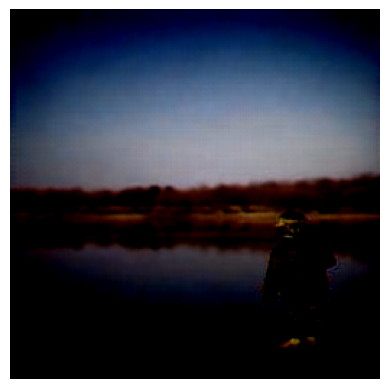

100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [61/500] | Encoder Loss: 0.0067329617373333 | Decoder Loss: 0.1475898450363182 | Discriminator Loss: 0.7045719784176993


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [62/500] | Encoder Loss: 0.007270325909363117 | Decoder Loss: 0.14758889073740222 | Discriminator Loss: 0.7065287003974001


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [63/500] | Encoder Loss: 0.006475362155731477 | Decoder Loss: 0.14759314372510968 | Discriminator Loss: 0.7054010758142986


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [64/500] | Encoder Loss: 0.006481444076941667 | Decoder Loss: 0.14759128277530215 | Discriminator Loss: 0.7047508473167876


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [65/500] | Encoder Loss: 0.006372284651650283 | Decoder Loss: 0.14759665531312635 | Discriminator Loss: 0.7046040653468606
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [66/500] | Encoder Loss: 0.0062492635006274645 | Decoder Loss: 0.1475898256737315 | Discriminator Loss: 0.7045714020015237


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [67/500] | Encoder Loss: 0.006041871729546678 | Decoder Loss: 0.14759002527790868 | Discriminator Loss: 0.7045494375114669


100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [68/500] | Encoder Loss: 0.006119904406703339 | Decoder Loss: 0.1475954258334851 | Discriminator Loss: 0.7044513446842126


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [69/500] | Encoder Loss: 0.006091618447558966 | Decoder Loss: 0.1475931299839191 | Discriminator Loss: 0.7046116708281511


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [70/500] | Encoder Loss: 0.00603167626806005 | Decoder Loss: 0.1475956413203371 | Discriminator Loss: 0.7044476491962365
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


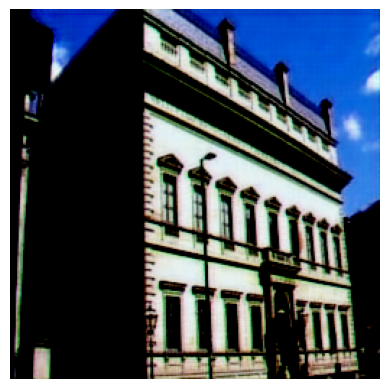

100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [71/500] | Encoder Loss: 0.006114470383464666 | Decoder Loss: 0.14759499021989855 | Discriminator Loss: 0.7044173029368509


100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [72/500] | Encoder Loss: 0.00600705357285183 | Decoder Loss: 0.14759418243419625 | Discriminator Loss: 0.7043444557104283


100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [73/500] | Encoder Loss: 0.005850299851255057 | Decoder Loss: 0.14759411122984514 | Discriminator Loss: 0.7043272124793001


100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Epoch [74/500] | Encoder Loss: 0.005925850072752929 | Decoder Loss: 0.14759415165036024 | Discriminator Loss: 0.7048751793935627


100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Epoch [75/500] | Encoder Loss: 0.005712479587175889 | Decoder Loss: 0.14759332476975676 | Discriminator Loss: 0.7043387154619137
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  6%|▌         | 10/167 [00:04<01:12,  2.15it/s]


KeyboardInterrupt: 

In [ ]:
main2()

100%|██████████| 167/167 [01:08<00:00,  2.44it/s]


Epoch [0/500] | Encoder Loss: 0.08090062740587903 | Decoder Loss: 0.3546530684668147 | Discriminator Loss: 0.7630752771200534
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


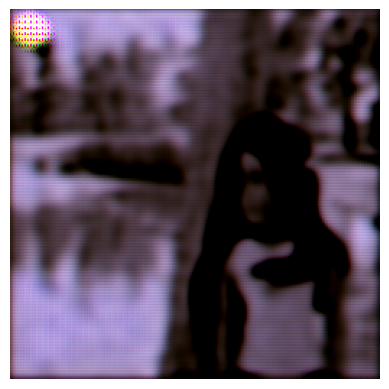

100%|██████████| 167/167 [01:08<00:00,  2.43it/s]


Epoch [1/500] | Encoder Loss: 0.055031526945308294 | Decoder Loss: 0.3505869216904669 | Discriminator Loss: 0.7366514609245483


100%|██████████| 167/167 [01:08<00:00,  2.42it/s]


Epoch [2/500] | Encoder Loss: 0.04321729802264425 | Decoder Loss: 0.35067655672570186 | Discriminator Loss: 0.7341009442677755


100%|██████████| 167/167 [01:09<00:00,  2.42it/s]


Epoch [3/500] | Encoder Loss: 0.0379032675890687 | Decoder Loss: 0.35039929376390877 | Discriminator Loss: 0.7310900302704223


100%|██████████| 167/167 [01:09<00:00,  2.41it/s]


Epoch [4/500] | Encoder Loss: 0.03151806893418292 | Decoder Loss: 0.35057024095586675 | Discriminator Loss: 0.7254362723784532


100%|██████████| 167/167 [01:09<00:00,  2.42it/s]


Epoch [5/500] | Encoder Loss: 0.029194664455459502 | Decoder Loss: 0.35056806627861753 | Discriminator Loss: 0.723290952736746
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 167/167 [01:09<00:00,  2.42it/s]


Epoch [6/500] | Encoder Loss: 0.02769419518550356 | Decoder Loss: 0.3505897703998817 | Discriminator Loss: 0.7219883713893548


100%|██████████| 167/167 [01:08<00:00,  2.42it/s]


Epoch [7/500] | Encoder Loss: 0.025756887901953594 | Decoder Loss: 0.35055936685579264 | Discriminator Loss: 0.7201213529723847


100%|██████████| 167/167 [01:08<00:00,  2.42it/s]


Epoch [8/500] | Encoder Loss: 0.024158841500917596 | Decoder Loss: 0.3507885868677836 | Discriminator Loss: 0.7184831928350255


100%|██████████| 167/167 [01:09<00:00,  2.42it/s]


Epoch [9/500] | Encoder Loss: 0.025713664027834367 | Decoder Loss: 0.3508556986640313 | Discriminator Loss: 0.7183763263468257


100%|██████████| 167/167 [01:08<00:00,  2.42it/s]


Epoch [10/500] | Encoder Loss: 0.023103474310326007 | Decoder Loss: 0.3504353012153488 | Discriminator Loss: 0.7156181895804262
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


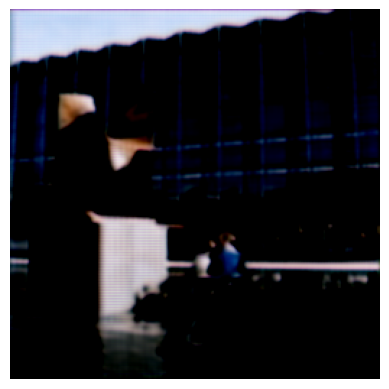

100%|██████████| 167/167 [01:08<00:00,  2.42it/s]


Epoch [11/500] | Encoder Loss: 0.022498115278155862 | Decoder Loss: 0.3507294890409458 | Discriminator Loss: 0.715197600290447


100%|██████████| 167/167 [01:09<00:00,  2.42it/s]


Epoch [12/500] | Encoder Loss: 0.021374310450461096 | Decoder Loss: 0.35033035385394523 | Discriminator Loss: 0.7127092323617307


100%|██████████| 167/167 [01:09<00:00,  2.42it/s]


Epoch [13/500] | Encoder Loss: 0.020030876147577505 | Decoder Loss: 0.3505516423436696 | Discriminator Loss: 0.7114969848872659


100%|██████████| 167/167 [01:08<00:00,  2.42it/s]


Epoch [14/500] | Encoder Loss: 0.03268440914323587 | Decoder Loss: 0.35064370582203663 | Discriminator Loss: 0.7260179230552948


100%|██████████| 167/167 [01:08<00:00,  2.42it/s]


Epoch [15/500] | Encoder Loss: 0.02045457967428747 | Decoder Loss: 0.35072222923090357 | Discriminator Loss: 0.7111789027373948
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 167/167 [01:08<00:00,  2.43it/s]


Epoch [16/500] | Encoder Loss: 0.018823475894813767 | Decoder Loss: 0.35056069689596486 | Discriminator Loss: 0.7093717145348737


100%|██████████| 167/167 [01:08<00:00,  2.42it/s]


Epoch [17/500] | Encoder Loss: 0.017686277198532743 | Decoder Loss: 0.3505746891755544 | Discriminator Loss: 0.7083232702609308


100%|██████████| 167/167 [01:08<00:00,  2.43it/s]


Epoch [18/500] | Encoder Loss: 0.01744964122660681 | Decoder Loss: 0.3505095279145384 | Discriminator Loss: 0.7077251790526384


100%|██████████| 167/167 [01:08<00:00,  2.42it/s]


Epoch [19/500] | Encoder Loss: 0.017102688935747047 | Decoder Loss: 0.35095179598488496 | Discriminator Loss: 0.7073721175422212


100%|██████████| 167/167 [01:08<00:00,  2.42it/s]


Epoch [20/500] | Encoder Loss: 0.0166033145798716 | Decoder Loss: 0.35055267810821533 | Discriminator Loss: 0.7071335062295377
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


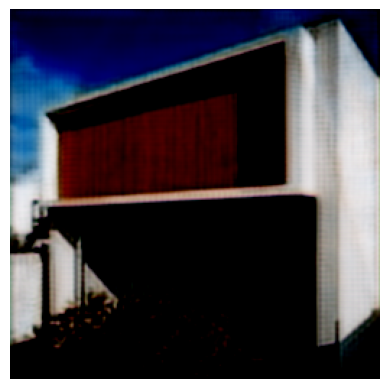

100%|██████████| 167/167 [01:09<00:00,  2.42it/s]


Epoch [21/500] | Encoder Loss: 0.016927823033964562 | Decoder Loss: 0.3507591336073276 | Discriminator Loss: 0.7074315287395866


100%|██████████| 167/167 [01:09<00:00,  2.42it/s]


Epoch [22/500] | Encoder Loss: 0.016405835485610063 | Decoder Loss: 0.35071034791940703 | Discriminator Loss: 0.7066111089940557


100%|██████████| 167/167 [01:09<00:00,  2.41it/s]


Epoch [23/500] | Encoder Loss: 0.023338975172913716 | Decoder Loss: 0.3507501666774293 | Discriminator Loss: 0.7142839260443956


100%|██████████| 167/167 [01:09<00:00,  2.41it/s]


Epoch [24/500] | Encoder Loss: 0.019959152224445772 | Decoder Loss: 0.35059300564720247 | Discriminator Loss: 0.7109462283328621


100%|██████████| 167/167 [01:09<00:00,  2.42it/s]


Epoch [25/500] | Encoder Loss: 0.01744912946764045 | Decoder Loss: 0.3507734494294949 | Discriminator Loss: 0.7068018513525317
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 167/167 [01:08<00:00,  2.42it/s]


Epoch [26/500] | Encoder Loss: 0.01662494894117117 | Decoder Loss: 0.3506866957613094 | Discriminator Loss: 0.7057326775111125


100%|██████████| 167/167 [01:08<00:00,  2.43it/s]


Epoch [27/500] | Encoder Loss: 0.015873889673032802 | Decoder Loss: 0.3508020958857622 | Discriminator Loss: 0.7057960504543281


100%|██████████| 167/167 [01:08<00:00,  2.43it/s]


Epoch [28/500] | Encoder Loss: 0.014985625821717842 | Decoder Loss: 0.350718845685799 | Discriminator Loss: 0.7053270115109975


100%|██████████| 167/167 [01:08<00:00,  2.43it/s]


Epoch [29/500] | Encoder Loss: 0.015435777258819448 | Decoder Loss: 0.35069723775286876 | Discriminator Loss: 0.7084731752287128


100%|██████████| 167/167 [01:08<00:00,  2.43it/s]


Epoch [30/500] | Encoder Loss: 0.014673470530636654 | Decoder Loss: 0.3507515427595127 | Discriminator Loss: 0.7054526609574964
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


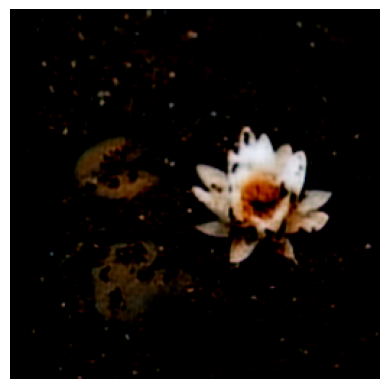

  5%|▌         | 9/167 [00:04<01:13,  2.16it/s]


KeyboardInterrupt: 

In [ ]:
main()

In [9]:
check = torch.load('/content/drive/MyDrive/disc.pth.tar')
disc = Discriminator().to(DEVICE)
opt_disc = optim.SGD(disc.parameters(), lr=LR_DISCRIMINATOR)
disc.load_state_dict(check['state_dict'])
opt_disc.load_state_dict(check['optimizer'])
check = torch.load('/content/drive/MyDrive/enc.pth.tar')
encoder = Encoder().to(DEVICE)
opt_enc = optim.Adam(encoder.parameters(), lr=LR_ENCODER)
encoder.load_state_dict(check['state_dict'])
opt_enc.load_state_dict(check['optimizer'])
check = torch.load('/content/drive/MyDrive/dec.pth.tar')
decoder = Decoder().to(DEVICE)
decoder.load_state_dict(check['state_dict'])
opt_dec = optim.Adam(decoder.parameters(), lr=LR_DECODER)
opt_dec.load_state_dict(check['optimizer'])

In [11]:
print("Num of parameters in encoder: ", sum(p.numel() for p in encoder.parameters()))
print("Num of parameters in decoder: ", sum(p.numel() for p in decoder.parameters()))
print("Num of parameters in discriminator: ", sum(p.numel() for p in disc.parameters()))

Num of parameters in encoder:  11680195
Num of parameters in decoder:  741379
Num of parameters in discriminator:  742665


In [12]:
train_dataset = MapDataset(root_dir_cover='/content/drive/MyDrive/Test/Cover', root_dir_hidden='/content/drive/MyDrive/Test/Hidden')
train_loader = DataLoader(
        train_dataset,
        batch_size=1,
        shuffle=False,
    )

In [13]:
from skimage.metrics import structural_similarity as ssim

In [14]:
def calculate_psnr_ssim(image_list):
    psnr_values = []
    ssim_values = []

    for (original_image, compared_image) in image_list:
        original_image = original_image[0].detach().permute(1,2,0).cpu().numpy()
        compared_image = compared_image[0].detach().permute(1,2,0).cpu().numpy()
        original_image = ((original_image + 1) * 127.5).astype(np.uint8)
        compared_image = ((compared_image + 1) * 127.5).astype(np.uint8)
        mse = np.mean((original_image - compared_image) ** 2)
        if mse == 0:
            psnr = 100
        else:
            max_pixel_value = 255.0
            psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))
        psnr_values.append(psnr)

        ss = ssim(original_image, compared_image, multichannel=True)
        ssim_values.append(ss)

    return psnr_values, ssim_values

In [15]:
total_psnr_encoder = 0.0
total_ssim_encoder = 0.0
total_psnr_decoder = 0.0
total_ssim_decoder = 0.0

In [16]:
for s, c in train_loader:
  secret1, cover1 = s.to(DEVICE), c.to(DEVICE)
  combined1 = torch.cat((cover1, secret1), 1)
  stego1 = encoder(combined1).to(DEVICE)
  retrieve1 = decoder(stego1).to(DEVICE)
  disc_result1 = disc(stego1).to(DEVICE)
  psnr_values1, ssim_values1 = calculate_psnr_ssim([(cover1, stego1)])
  psnr_values2, ssim_values2 = calculate_psnr_ssim([(secret1, retrieve1)])
  total_psnr_encoder += psnr_values1[0]
  total_ssim_encoder += ssim_values1[0]
  total_psnr_decoder += psnr_values2[0]
  total_ssim_decoder += ssim_values2[0]

average_psnr_encoder = total_psnr_encoder / len(train_loader)
average_ssim_encoder = total_ssim_encoder / len(train_loader)
average_psnr_decoder = total_psnr_decoder / len(train_loader)
average_ssim_decoder = total_ssim_decoder / len(train_loader)
print(f"Average PSNR of encoder= {average_psnr_encoder:.2f}, Average SSIM encoder= {average_ssim_encoder:.2f}")
print(f"Average PSNR of decoder= {average_psnr_decoder:.2f}, Average SSIM decoder= {average_ssim_decoder:.2f}")

<ipython-input-14-4728bd6c3710>:18: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ss = ssim(original_image, compared_image, multichannel=True)


Average PSNR of encoder= 27.89, Average SSIM encoder= 0.05
Average PSNR of decoder= 28.08, Average SSIM decoder= 0.32
